In [12]:
import os
import numpy as np
import pandas as pd
import time
import warnings
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
import sklearn.metrics
from sklearn.metrics import balanced_accuracy_score


### Data Preprocessing

Contents of train_x.csv: arr of shape (2102, 784)
Contents of valid_x.csv: arr of shape (600, 784)


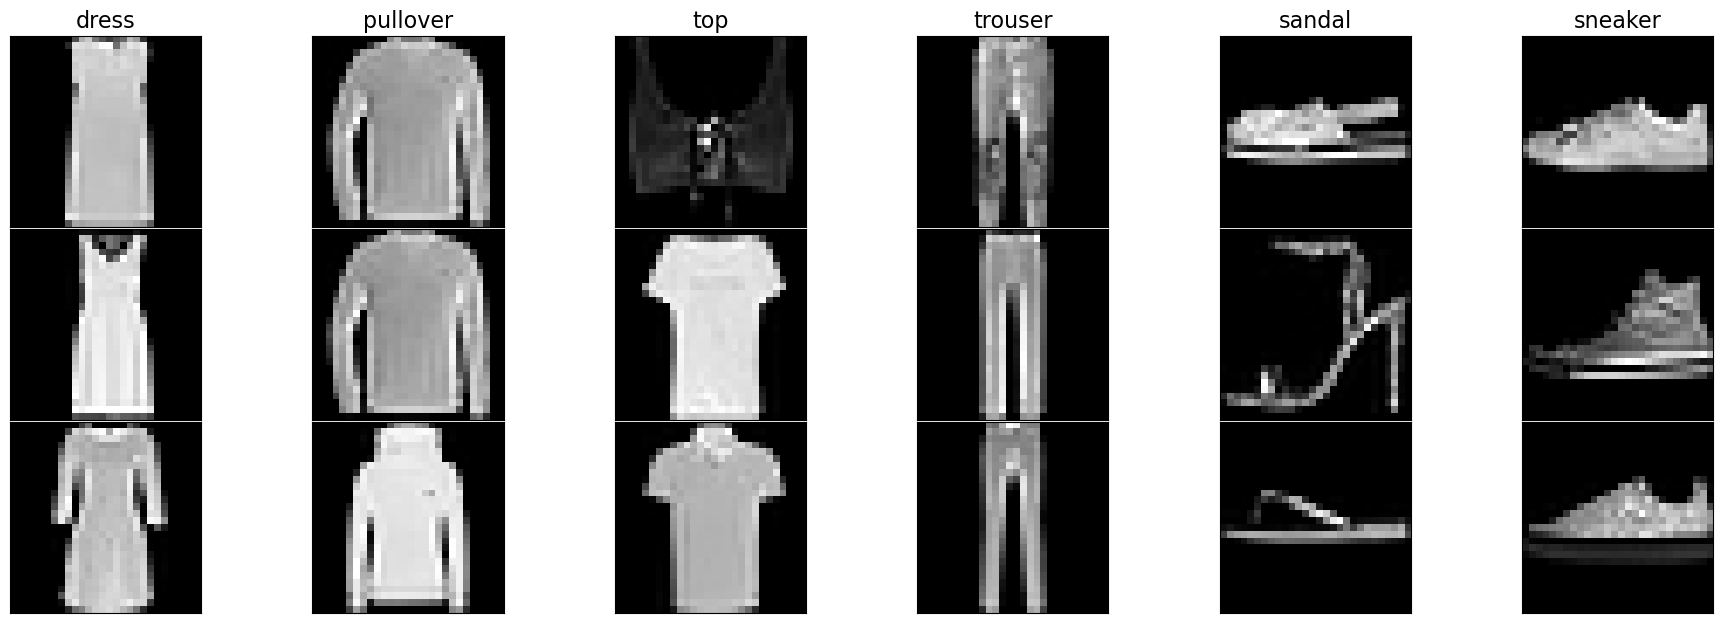

In [2]:
%run load_and_plot_data.py

In [3]:
train_y_df, valid_y_df

(     class_name  class_uid
 0      pullover          2
 1           top          0
 2         dress          3
 3        sandal          5
 4      pullover          2
 ...         ...        ...
 2097     sandal          5
 2098     sandal          5
 2099     sandal          5
 2100     sandal          5
 2101     sandal          5
 
 [2102 rows x 2 columns],
     class_name  class_uid
 0        dress          3
 1        dress          3
 2        dress          3
 3        dress          3
 4        dress          3
 ..         ...        ...
 595    sneaker          7
 596    sneaker          7
 597        top          0
 598        top          0
 599    trouser          1
 
 [600 rows x 2 columns])

In [4]:
temp = np.array(train_y_df)
count_array = temp[:,1]
count_train = np.unique(count_array, return_counts = True)

temp = np.array(valid_y_df)
count_array = temp[:,1]
count_valid = np.unique(count_array, return_counts = True)

In [5]:
count_train, count_valid

((array([0, 1, 2, 3, 5, 7], dtype=object),
  array([  1,   1, 100, 400, 800, 800])),
 (array([0, 1, 2, 3, 5, 7], dtype=object),
  array([100, 100, 100, 100, 100, 100])))

In [6]:
train_y = np.array(train_y_df['class_uid'])
train_y

array([2, 0, 3, ..., 5, 5, 5])

In [7]:
train_x.shape, train_x[0].dtype

((2102, 784), dtype('int64'))

In [8]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(train_x)
print(np.sum(scaler.transform(train_x)))

301797.8567070458


In [29]:
normed_train_x = sklearn.preprocessing.normalize(train_x, norm = 'max', axis = 1)
normed_valid_x = sklearn.preprocessing.normalize(valid_x, norm = 'l1', axis = 1)
normed_valid_x.shape

(600, 784)

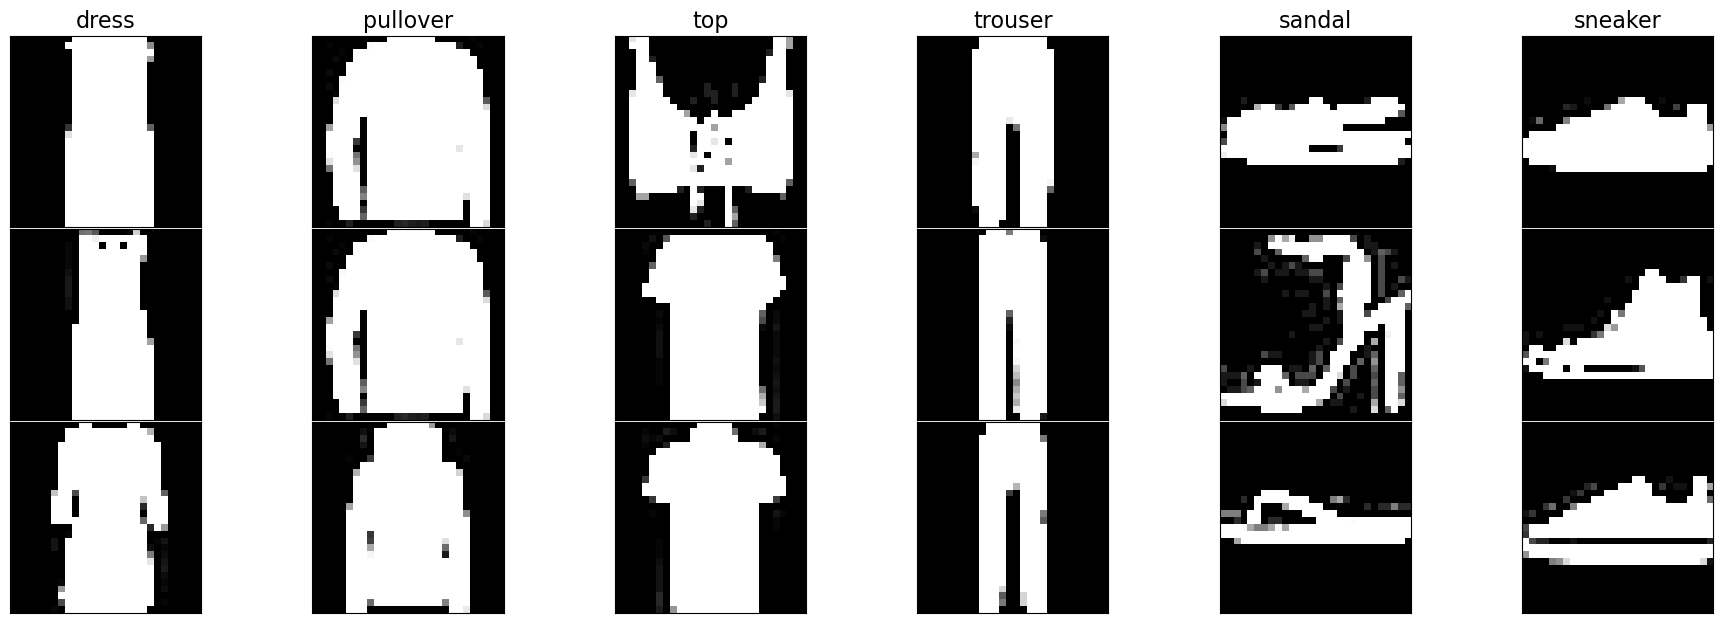

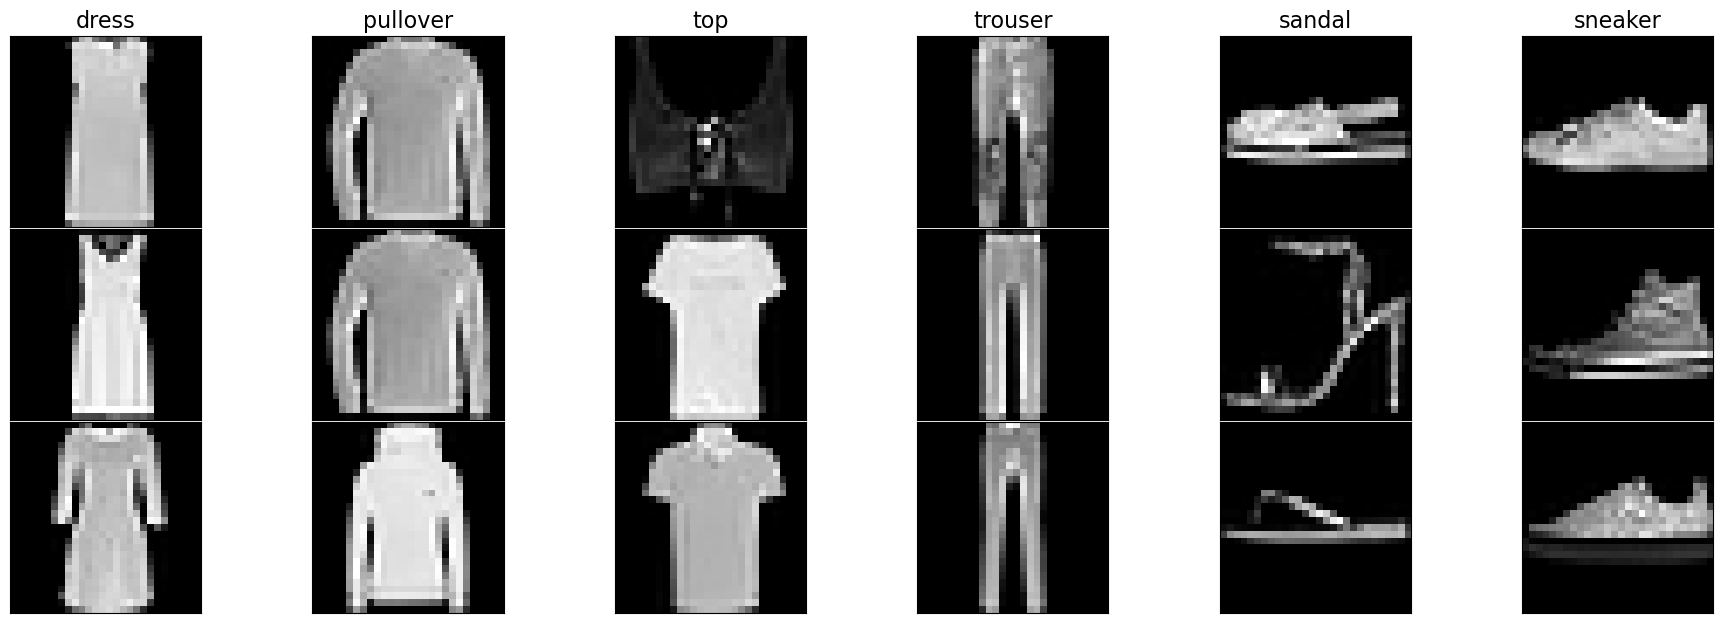

In [31]:
prng = np.random.RandomState(0)
N = 3 # num examples of each class to show
fig, axgrid = plt.subplots(N, 6, figsize=(6*3, N*2.5))

for ll, label in enumerate(['dress', 'pullover', 'top', 'trouser', 'sandal', 'sneaker']):
    match_df = valid_y_df.query("class_name == '%s'" % label)
    match_ids_N = prng.choice(match_df.index, size=N)        
    for ii, row_id in enumerate(match_ids_N):
        ax = axgrid[ii, ll]
        x_SS = normed_valid_x[row_id].reshape((28,28))
        ax.imshow(x_SS, vmin=0, vmax=255/normed_valid_x.shape[0]/normed_valid_x[0].shape[0], cmap='gray')
        ax.set_xticks([]); ax.set_yticks([]);
        if ii == 0:
            ax.set_title(label, fontsize=16)
plt.subplots_adjust(left=0.01, right=0.99, wspace=.2, hspace=.01)
#plt.tight_layout();
plt.show();

prng = np.random.RandomState(0)
N = 3 # num examples of each class to show
fig, axgrid = plt.subplots(N, 6, figsize=(6*3, N*2.5))

for ll, label in enumerate(['dress', 'pullover', 'top', 'trouser', 'sandal', 'sneaker']):
    match_df = valid_y_df.query("class_name == '%s'" % label)
    match_ids_N = prng.choice(match_df.index, size=N)        
    for ii, row_id in enumerate(match_ids_N):
        ax = axgrid[ii, ll]
        x_SS = valid_x[row_id].reshape((28,28))
        ax.imshow(x_SS, vmin=0, vmax=255, cmap='gray')
        ax.set_xticks([]); ax.set_yticks([]);
        if ii == 0:
            ax.set_title(label, fontsize=16)
plt.subplots_adjust(left=0.01, right=0.99, wspace=.2, hspace=.01)
#plt.tight_layout();
plt.show();




In [10]:
mlp = MLPClassifier(
            activation='relu',
            max_iter=1000,
            solver='sgd',
            learning_rate='adaptive', 
            momentum=0.0,
            tol=1e-5,
            )

In [11]:
mlp_hyperparameter_grid = dict(
    hidden_layer_sizes = [(16, )], #[(16,), (32,), (64,)],
    random_state = [101, 111, 123, 321],
    batch_size= [32], #[32, 64, 128],
    learning_rate_init= [0.001, 0.005, 0.0005], 
    n_iter_no_change=[10, 25, 50],
    alpha=[0.1, 0.01, 0.001, 0.0001]
    )

In [12]:
valid_y = np.array(valid_y_df['class_uid'])
valid_y.shape, train_y.shape

((600,), (2102,))

### fit on train

In [13]:
### splitter
valid_indicators_L = np.hstack([
    -1 * np.ones(int(0.8 * train_y.size)), # -1 means never include this example in any test split
    0  * np.ones(train_y.size - int(0.8 * train_y.size)), #  0 means include in the first test split (we count starting at 0 in python)
    ])
my_splitter = sklearn.model_selection.PredefinedSplit(valid_indicators_L)

In [55]:
mlp_searcher = sklearn.model_selection.GridSearchCV(estimator = mlp,
                                                    param_grid = mlp_hyperparameter_grid,
                                                    scoring = 'balanced_accuracy',
                                                    cv = my_splitter,
                                                    return_train_score = True,
                                                    refit=False
                                                   )

In [60]:
start_time_sec = time.time()
mlp_searcher.fit(normed_train_x, train_y)
elapsed_time_sec = time.time() - start_time_sec

/Users/richardwang/micromamba/envs/cs135_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richardwang/micromamba/envs/cs135_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richardwang/micromamba/envs/cs135_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richardwang/micromamba/envs/cs135_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and 

In [41]:
mlp_searcher_result = pd.DataFrame(mlp_searcher.cv_results_).copy()
[mlp_searcher_result.mean_test_score, mlp_searcher_result.params]

[0     0.946063
 1     0.946301
 2     0.939038
 3     0.948326
 4     0.943563
 5     0.939276
 6     0.950588
 7     0.960113
 8     0.945826
 9     0.936538
 10    0.948801
 11    0.927251
 12    0.939276
 13    0.943563
 14    0.920464
 15    0.948326
 16    0.960113
 17    0.929751
 18    0.924751
 19    0.946301
 20    0.920701
 21    0.920464
 22    0.945826
 23    0.916176
 24    0.932251
 25    0.955351
 26    0.915701
 Name: mean_test_score, dtype: float64,
 0     {'batch_size': 32, 'hidden_layer_sizes': (16,)...
 1     {'batch_size': 32, 'hidden_layer_sizes': (16,)...
 2     {'batch_size': 32, 'hidden_layer_sizes': (16,)...
 3     {'batch_size': 32, 'hidden_layer_sizes': (32,)...
 4     {'batch_size': 32, 'hidden_layer_sizes': (32,)...
 5     {'batch_size': 32, 'hidden_layer_sizes': (32,)...
 6     {'batch_size': 32, 'hidden_layer_sizes': (64,)...
 7     {'batch_size': 32, 'hidden_layer_sizes': (64,)...
 8     {'batch_size': 32, 'hidden_layer_sizes': (64,)...
 9     {'batch_

In [42]:
mlp_searcher.best_params_

{'batch_size': 32,
 'hidden_layer_sizes': (64,),
 'learning_rate_init': 0.005,
 'random_state': 101}

In [14]:
best_mlp = mlp # TODO call set_params using the best_params_ found by your searcher
best_param = mlp_searcher.best_params_
best_mlp.set_params(**best_param)
best_mlp.fit(normed_train_x, train_y)

NameError: name 'mlp_searcher' is not defined

In [57]:
normed_valid_x = sklearn.preprocessing.normalize(valid_x, norm = 'max', axis = 1)

pred_y = best_mlp.predict(normed_valid_x)
best_mlp_BAcc = balanced_accuracy_score(pred_y, valid_y)
best_mlp_BAcc

0.8471693874561117

In [59]:
pred_y.shape

(600,)

In [ ]:
# batch_size = 100

# max_iter_per_run = 2000 # Don't touch. Has been set so wallclock times are comparable.

# lr_list = [0.001, 0.0001, 0.0005, 0.005]
# n_runs = 1
# mlp_list_by_lr_500 = dict()



# for lr in lr_list:
#     mlp_list_by_lr_500[lr] = list()
#     for run_id, random_state in enumerate(range(n_runs)):
#         start_time_sec = time.time()
#         mlp = MLPClassifier(
#             hidden_layer_sizes = [64],
#             activation='relu',
#             alpha=0.0001,
#             random_state=random_state, # controls random init of weights
#             max_iter=max_iter_per_run,
#             solver='sgd',
#             batch_size=batch_size,
#             learning_rate='adaptive', learning_rate_init=lr, momentum=0.0,
#             tol=1e-5,
#             n_iter_no_change=50,
#             )

#         with warnings.catch_warnings(record=True) as warn_list:
#             mlp.fit(train_x, train_y)
#         mlp.elapsed_time_sec_ = time.time() - start_time_sec
#         mlp.n_epoch_ = len(mlp.loss_curve_)
#         mlp.did_converge = True if len(warn_list) == 0 else False
        
#         # Add to the list
#         mlp_list_by_lr_500[lr].append(mlp)
        
#         pred_y = mlp.predict(train_x)
#         print(pred_y[:5])
#         print(pred_y[5:])
        
#         print(np.unique(pred_y, return_counts = True))
        
#         # Pretty print summary of this run
#         print('finished run %2d/%d after %5.1f sec | %13s after %4d iter | tr loss % .3f | balacc % .3f | lr = %.3f' % (
#             run_id + 1, n_runs,
#             mlp.elapsed_time_sec_,
#             'yes converged' if mlp.did_converge else 'NOT converged',
#             mlp.n_epoch_,
#             mlp.loss_ / np.log(2.0),
#             balanced_accuracy_score(train_y, pred_y),
#             lr))

